In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.diagnostic import plot_covariance_contour, plot_covariance_corner
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import mrdv1, scirdv1, Orbits, DefaultOrbits, LISAModel, EqualArmlengthOrbits
from lisatools.utils.constants import *
from lisatools.sources import BBHCalculationController, GBCalculationController, EMRICalculationController
from lisatools.sources.emri import EMRITDIWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform
from lisatools.stochastic import StochasticContribution, StochasticContributionContainer

import os
from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.


## Define Stochastic Contributions

In [2]:
from dataclasses import dataclass

@dataclass
class GWBModel:
    name: str
    fn: np.ndarray  # frequencies
    Sh: np.ndarray  # FFD PSD (1/HZ)

class WorstCaseFromKB(StochasticContribution):
    outside_return_val = np.inf
    @classmethod
    def specific_Sh_function(
        cls, f: float | np.ndarray, stoch_model: GWBModel
    ) -> float | np.ndarray:
        """Calculate the power spectral density contained in a stochastic signal contribution.

        ## PERFORMS LINEAR INTERPOLATION with Numpy

        Args:
            f: Frequency array.
            *args: Any arguments for the function.
            **kwargs: Any keyword arguments for the function.

        Returns:
            Power spectral density contained in stochastic signal.

        """

        return np.interp(f, stoch_model.fn, stoch_model.Sh, left=cls.outside_return_val, right=cls.outside_return_val)


In [3]:

# stochastic_contributions = {}
# path_to_models_folder = "../space_2050_models/"
# for fp in os.listdir(path_to_models_folder):
#     if fp[:3] == "GWB":
#         name = fp.split(".dat")[0]
#         f, hn = np.genfromtxt(path_to_models_folder + fp).T

#         Sn = hn ** 2 / f
#         plt.loglog(f, Sn, label=name)
#         plt.xlabel("Frequency (Hz)")
#         plt.ylabel("FFD PSD (1/Hz)")
#         print(name)

#         stochastic_contributions[name] = GWBModel(name, f, Sn)
        
# plt.legend()

In [4]:
# Define a frequency axis
f = np.logspace(-4, 0, 1000)

In [5]:
def get_df(Tobs: float, dt: float) -> float:
    Nobs = int(Tobs / dt)
    Tobs = Nobs * dt
    df = 1 / Tobs
    return df


In [6]:
# for stoch in ["GWB_LISA_HS", "GWB_LISA_LS"]:
#     psd_kwargs = dict(
#         stochastic_function=Space2050GWB,
#         stochastic_params=(stochastic_contributions[stoch],),
#     )
#     missions["lisa_" + stoch] = dict(
#         model=lisa,
#         psd_kwargs=psd_kwargs,
#         Tobs=YRSID_SI, 
#         dt=10.0
#     )

### With and without stochastic contribution

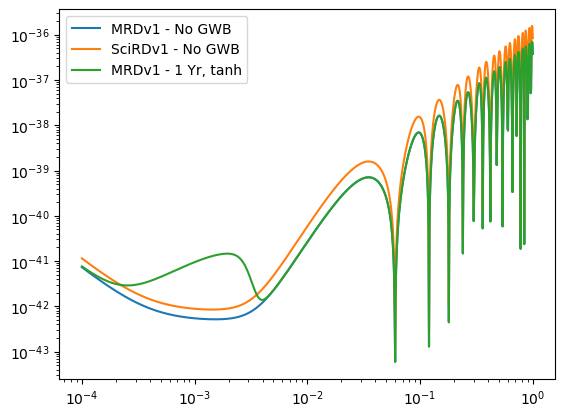

In [7]:
fn = f.copy()
Sn_no_GWB_mrd = get_sensitivity(fn, model=mrdv1, sens_fn=A1TDISens)
plt.loglog(fn, Sn_no_GWB_mrd, c=f"C0", label="MRDv1 - No GWB")
Sn_no_GWB_srd = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens)
plt.loglog(fn, Sn_no_GWB_srd, c=f"C1", label="SciRDv1 - No GWB")
Sn_with_GWB_1yr = get_sensitivity(fn, model=mrdv1, sens_fn=A1TDISens, stochastic_params=(YRSID_SI,))
plt.loglog(fn, Sn_with_GWB_1yr, c=f"C2", label="MRDv1 - 1 Yr, tanh")
plt.legend()


## Diagnostics

Setup all snr calculators

In [8]:
calculators = {}
orbits_here = EqualArmlengthOrbits()
Tobs = 4.0 * YRSID_SI
dt = 10.0

psd_kwargs = dict(
    stochastic_params=(Tobs,),
)

# black hole generator
bbh = BBHSNRWaveform(response_kwargs=dict(TDItag="AET", orbits=orbits_here, tdi2=False))

calculators["bbh"] = BBHCalculationController(
    bbh, 
    mrdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)

# gb generator
gb = GBAETWaveform(orbits=orbits_here)

calculators["gb"] = GBCalculationController(
    gb, 
    mrdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)

# emri generator
emri = EMRITDIWaveform(
    T=Tobs / YRSID_SI, 
    dt=dt, 
    response_kwargs=dict(tdi="1st generation", orbits=orbits_here)
)

calculators["emri"] = EMRICalculationController(
    emri, 
    mrdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)
    


Data file FluxNewMinusPNScaled_fixed_y_order.dat not found. Downloading now.


Output()

Data file SchwarzschildEccentricInput.hdf5 not found. Downloading now.


Output()

Data file AmplitudeVectorNorm.dat not found. Downloading now.


Output()

### MBHBs

2012.3410144949164


Text(0, 0.5, 'Char strain')

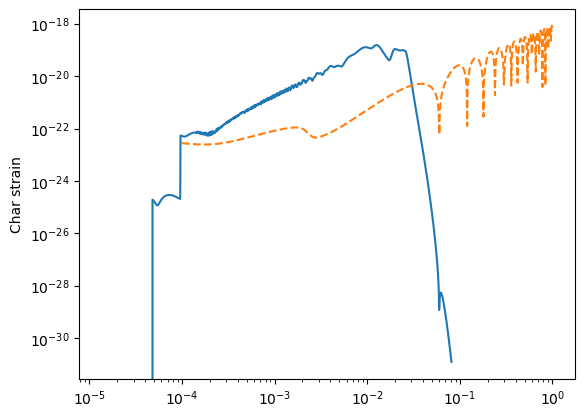

In [9]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)

print(calculators["bbh"].get_snr(*mbh_injection_params))
Sn = get_sensitivity(fn, model=mrdv1, sens_fn=A1TDISens, **psd_kwargs)
plt.loglog(calculators["bbh"].f_arr, calculators["bbh"].f_arr * np.abs(calculators["bbh"].last_output[0]), c=f"C0")
df = get_df(Tobs, dt)
plt.loglog(fn, np.sqrt(fn) * Sn ** (1/2), c=f"C1", ls="--")
plt.ylabel("Char strain")

In [10]:
# example with last mission
scaled_inj_params, cov = calculators["bbh"].get_cov(
    *mbh_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-9,
    deriv_inds=None,
)


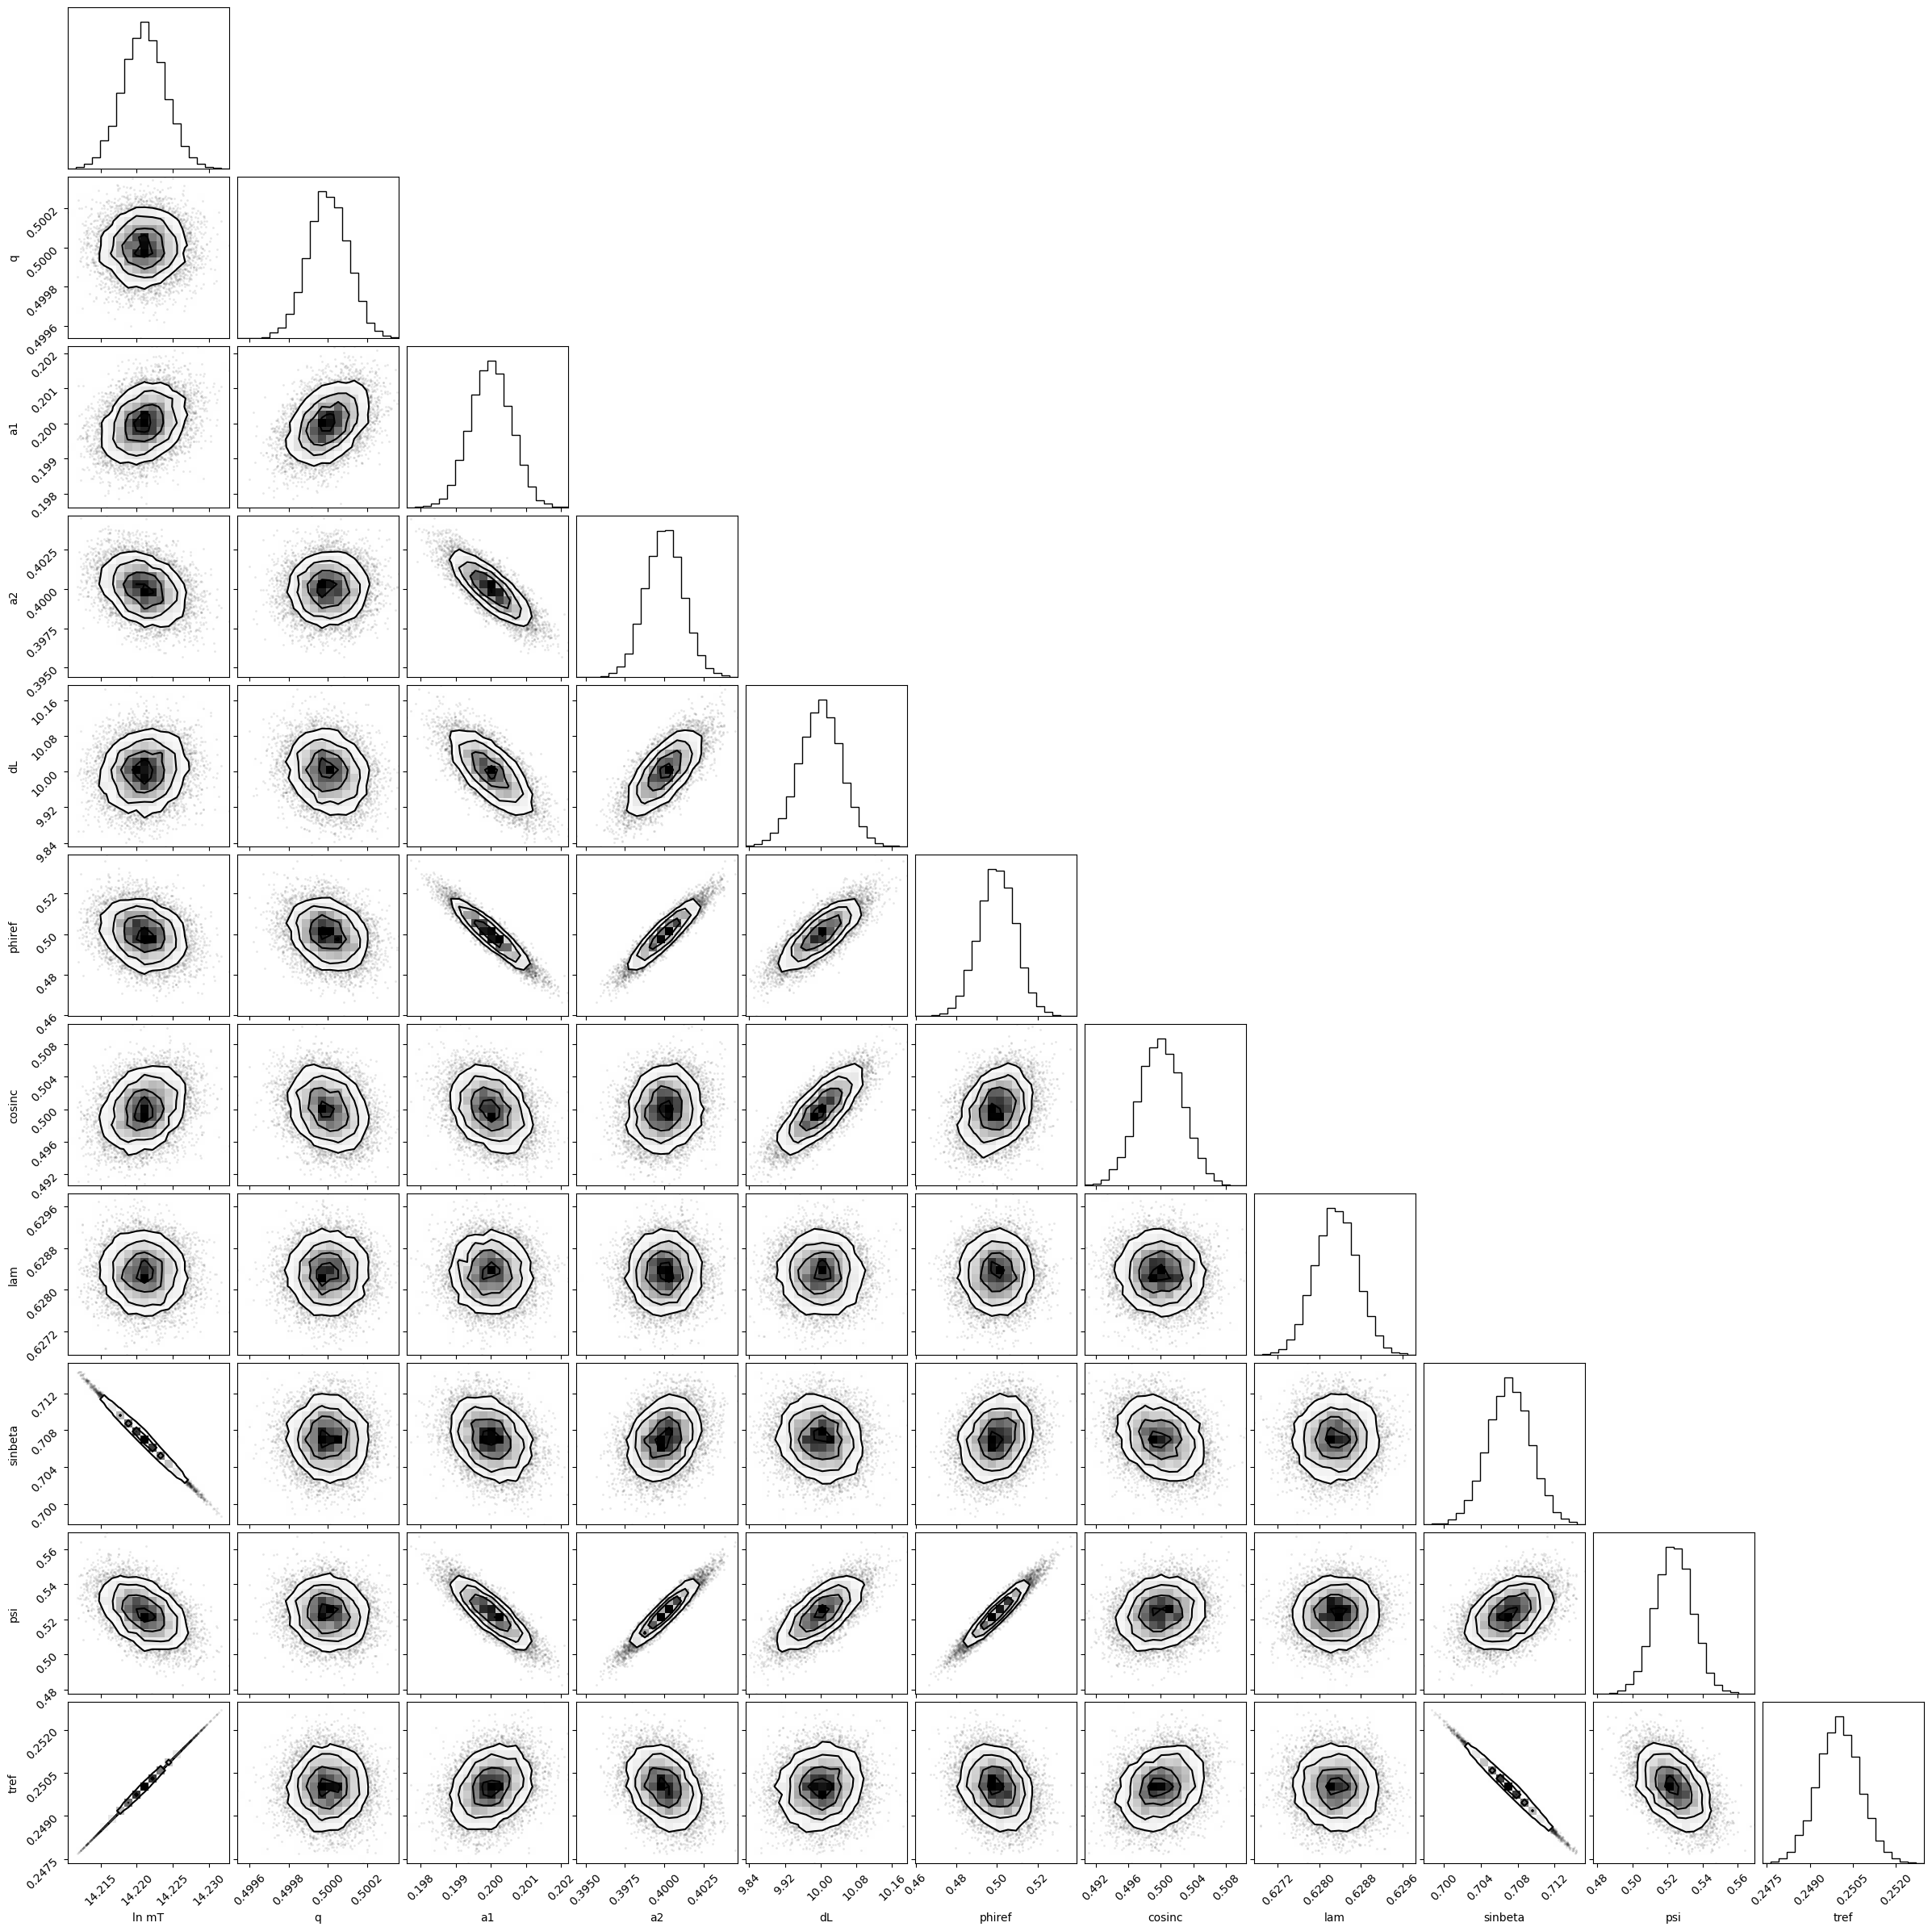

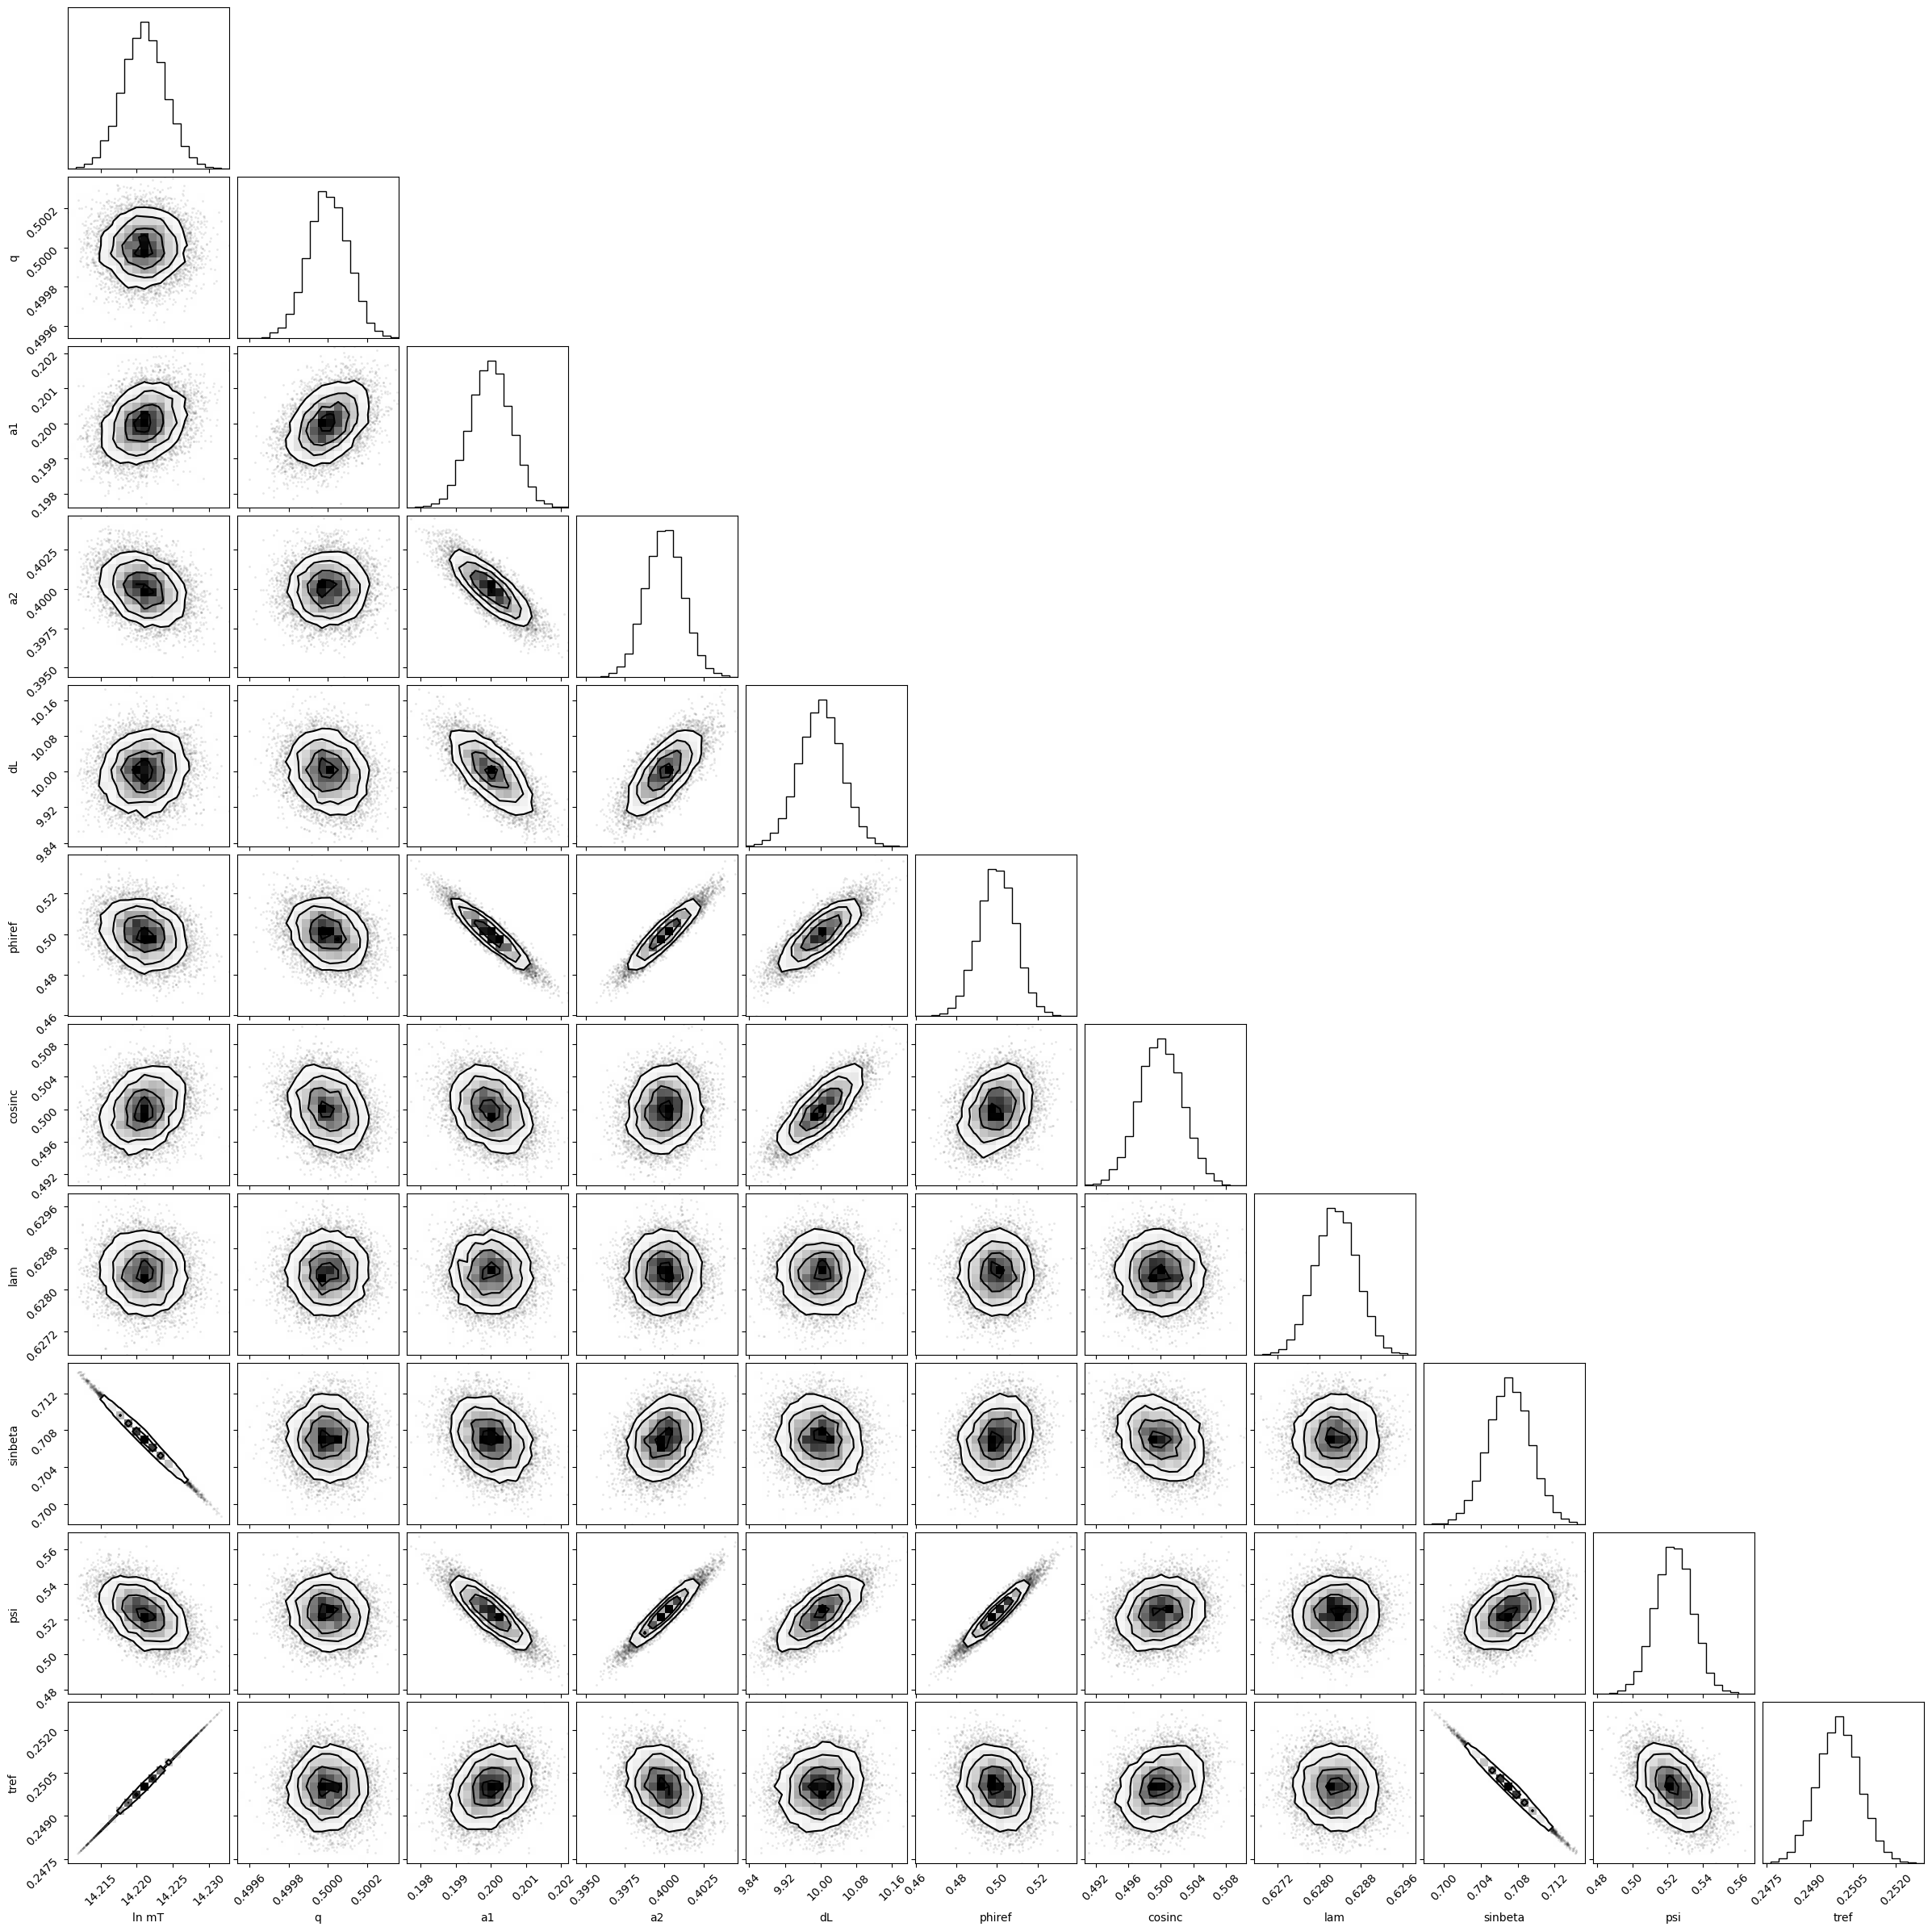

In [11]:
labels=["ln mT", "q", "a1", "a2", "dL", "phiref", "cosinc", "lam", "sinbeta", "psi", "tref"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

### GBs

276.75301598116033


Text(0, 0.5, 'Char strain')

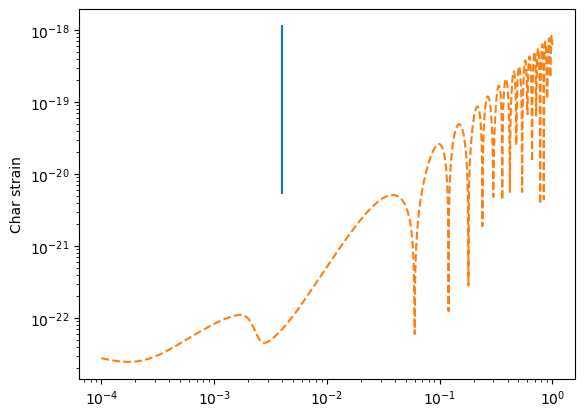

In [12]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])

print(calculators["gb"].get_snr(*gb_injection_params))
Sn = get_sensitivity(fn, model=mrdv1, sens_fn=A1TDISens, **psd_kwargs)
plt.loglog(calculators["gb"].f_arr, calculators["gb"].f_arr * np.abs(calculators["gb"].last_output[0]), c=f"C0")
df = get_df(Tobs, dt)
plt.loglog(fn, np.sqrt(fn) * Sn ** (1/2), c=f"C1", ls="--")
plt.ylabel("Char strain")

In [13]:
scaled_inj_params, cov = calculators["gb"].get_cov(
    *gb_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-11,
    deriv_inds=None,
)

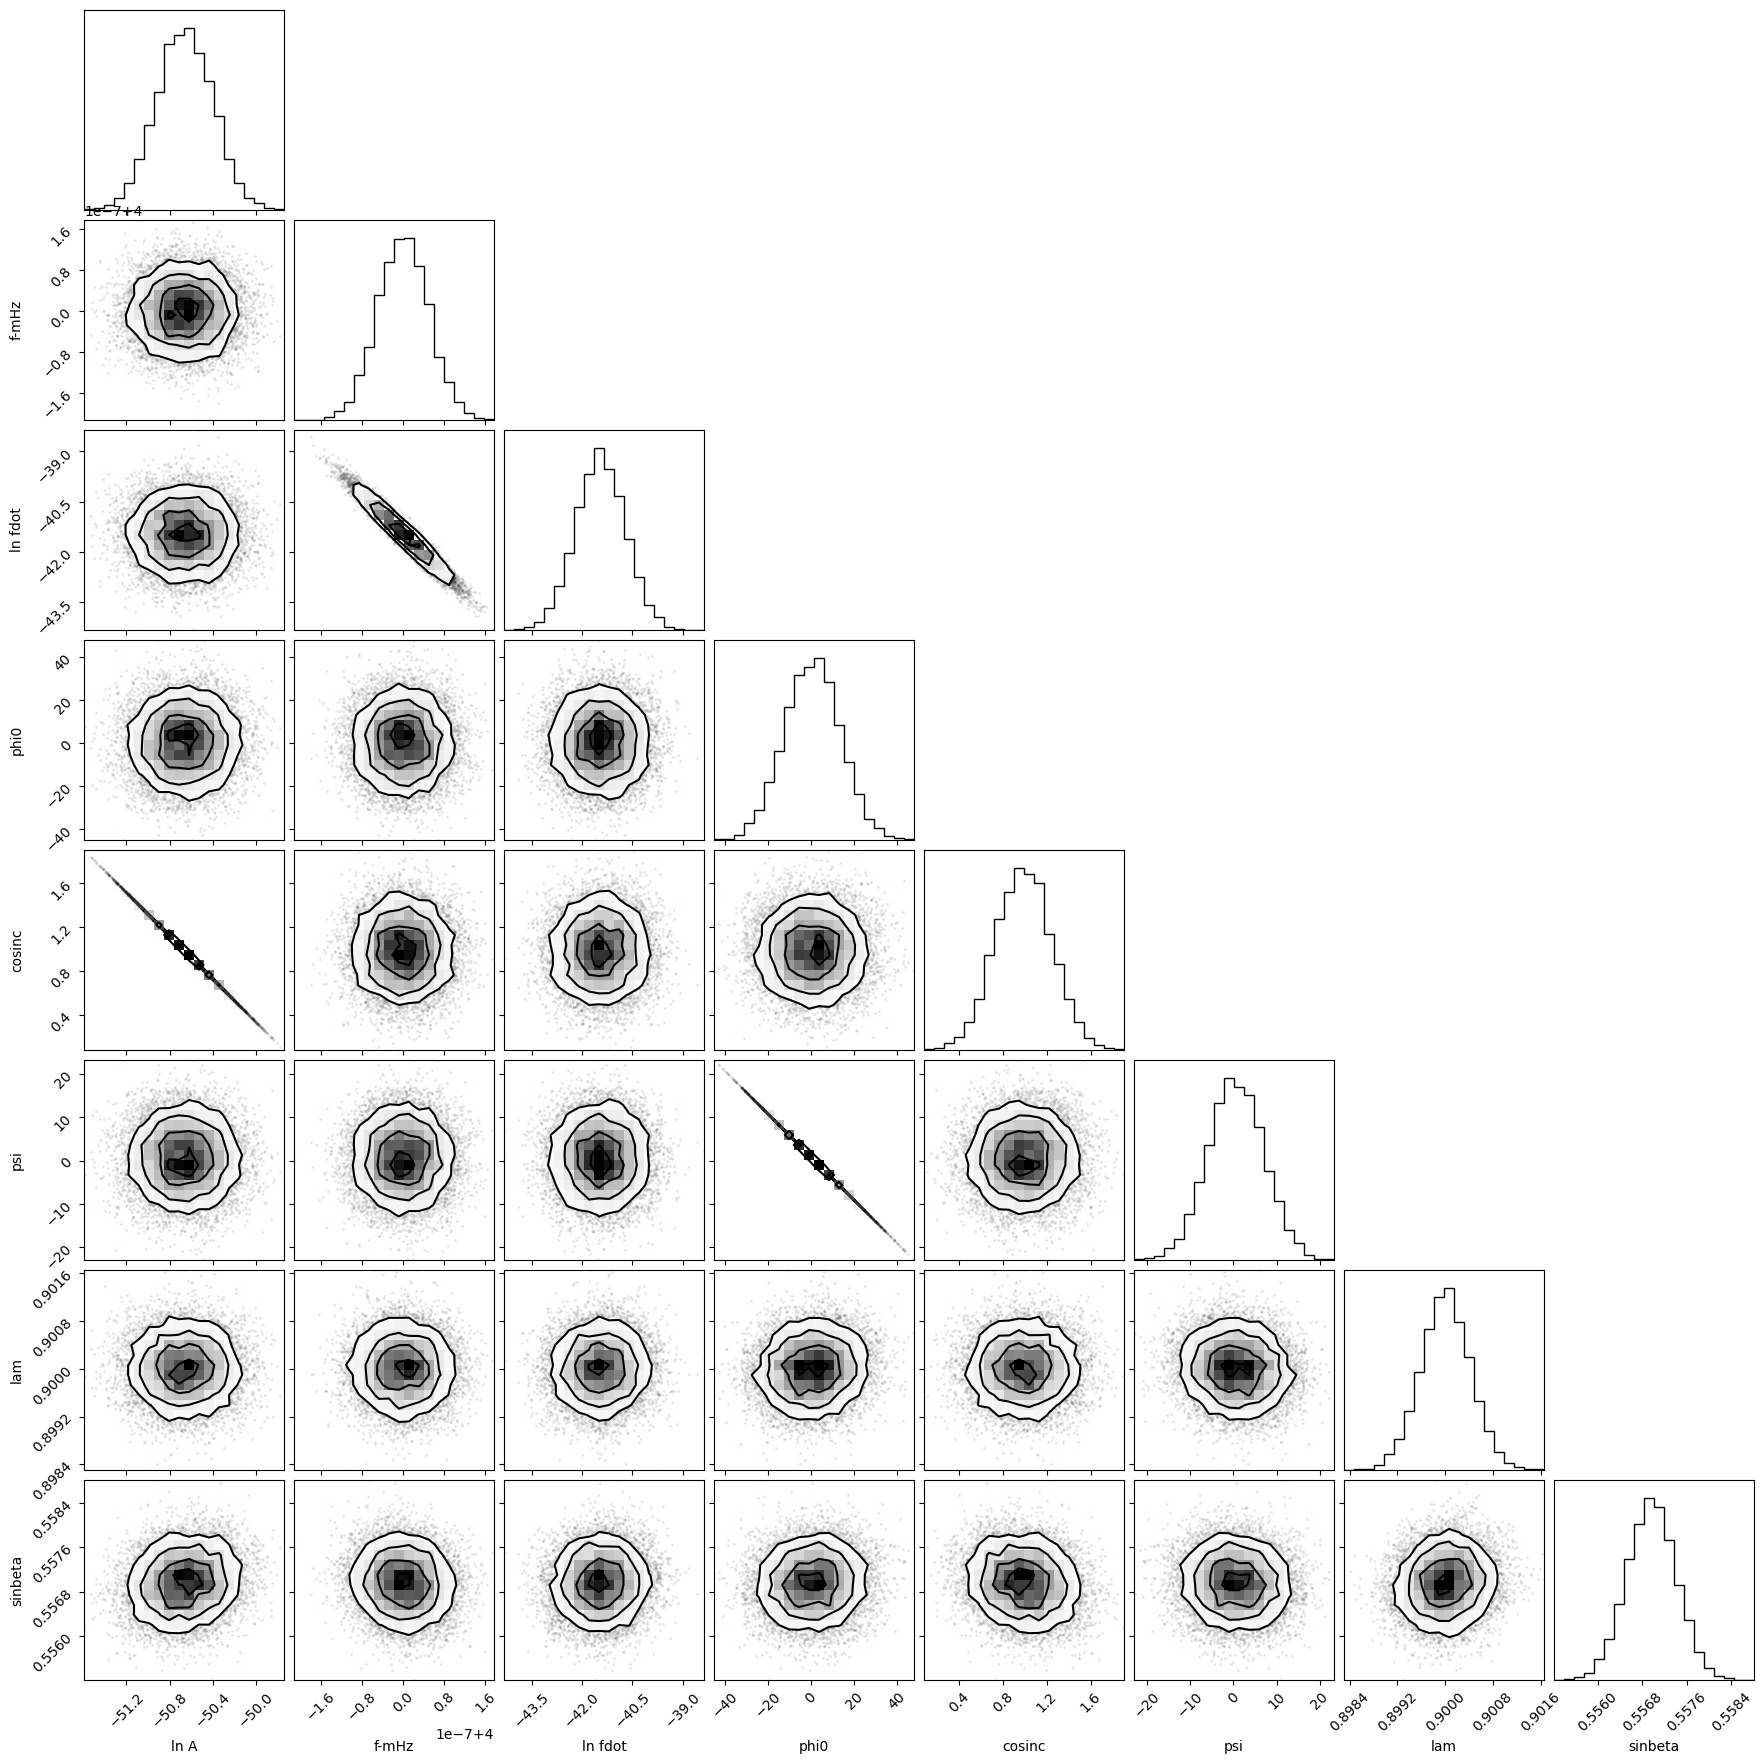

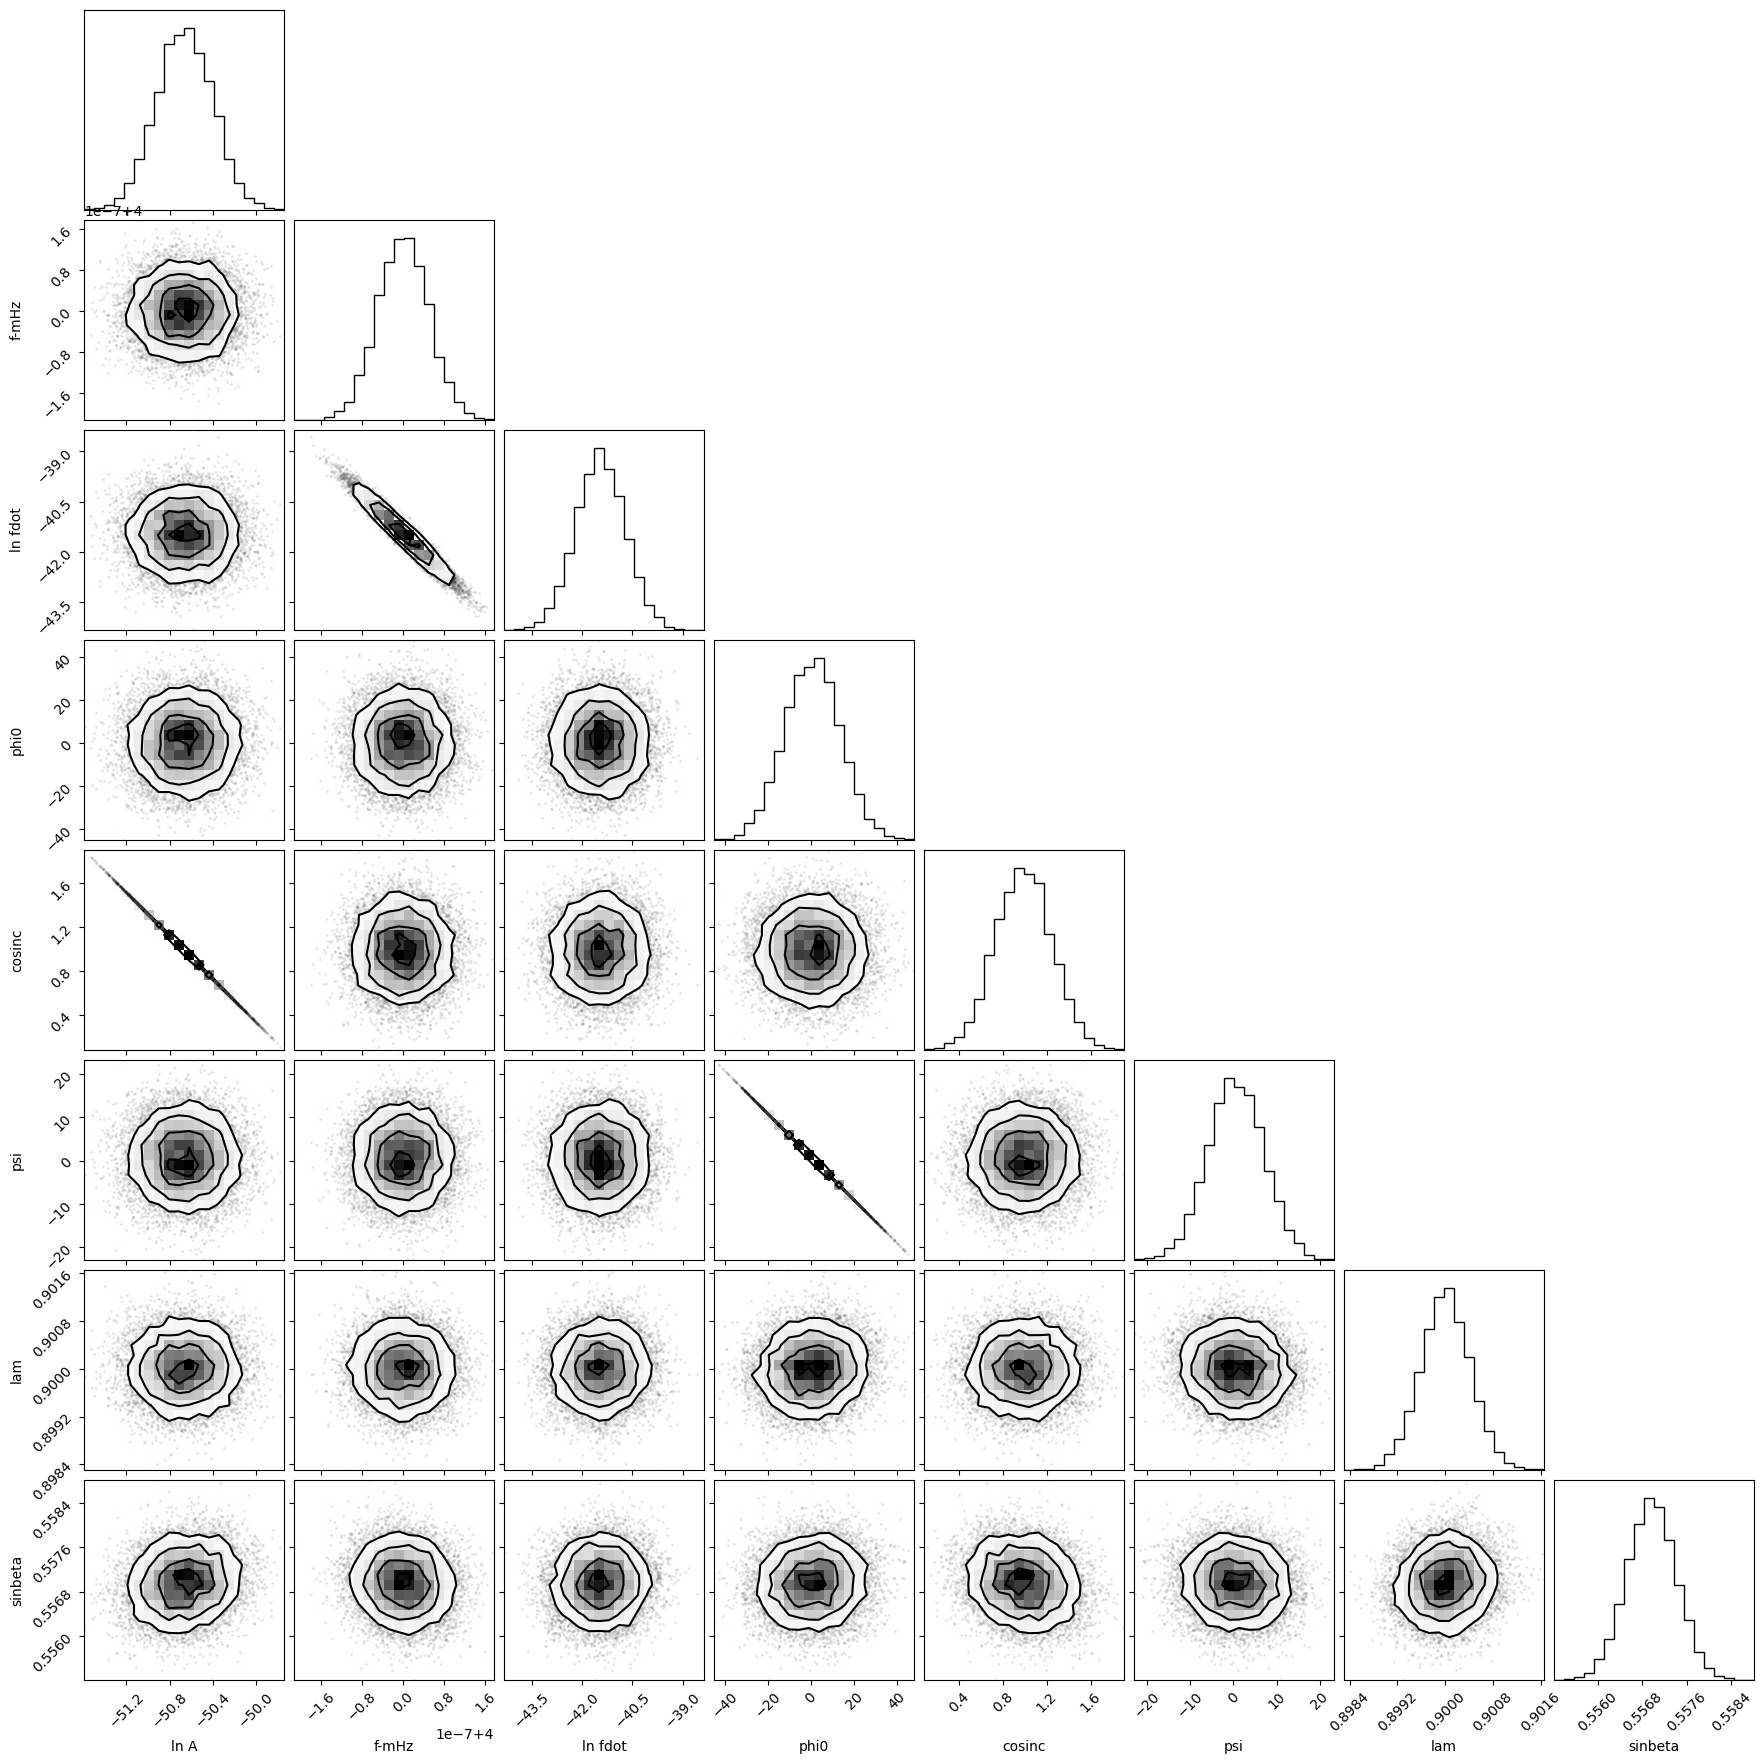

In [14]:
labels=["ln A", "f-mHz", "ln fdot", "phi0", "cosinc", "psi", "lam", "sinbeta"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

#### VGBs Specifically

In [15]:
vgbs = pd.read_csv("vgbs.txt")

b'HPLib' 42.8867361959973
b'ZTFJ2320' 0.3431074338561142
b'SDSSJ0923' 4.753413948294384
b'AMCVn' 80.61234414908614
b'CX1751' 4.3928855740370585
b'ZTFJ2029' 3.4947712055726896
b'SDSSJ0935' 42.328345933168734
b'ZTFJ1539' 125.44871674594657
b'SDSSJ2322' 19.85435555311537
b'4U1820-30' 18.980555810556822
b'HMCnc' 213.86319390074922
b'CRBoo' 17.984334623067536
b'PTFJ0533' 5.508770768557017
b'HD265435' 2.8761789132513647
b'CDm30' 4.361102594327593
b'ZTFJ0640' 0.5138851922581186
b'ZTFJ1749' 2.8554989490033456
b'SMSSJ0338' 5.622156880817613
b'SDSSJ1630' 4.049044256206672
b'ZTFJ2055' 0.5855099210779459
b'ZTFJ1901' 1.8906682934223524
b'ZTFJ1946' 0.8524849023275773
b'ESCet' 167.8909143962329
b'SDSSJ1337' 5.549438881509396
b'ZTFJ2130' 1.947158557264624
b'V407Vul' 181.25444887672217
b'ZTFJ2243' 116.11797846803145
b'SDSSJ0634' 19.365136534861854
b'ZTFJ0722' 6.5256144297036895
b'PTF1919' 3.105499086747195
b'V803Cen' 21.09426941199971
b'SDSSJ1351' 20.10687057937476
b'SDSSJ1235' 4.7237457676109535
b'ZTF

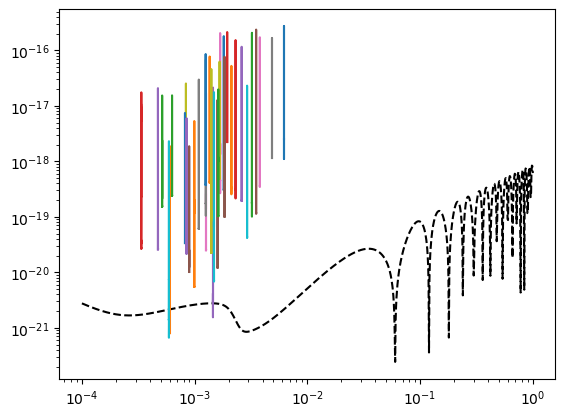

In [18]:
Sn = get_sensitivity(fn, model=mrdv1, sens_fn=A1TDISens, **psd_kwargs)
df = get_df(Tobs, dt)
plt.loglog(fn, Sn ** (1/2), c=f"k", ls="--")
for j in range(len(vgbs)):
    vgb = vgbs.iloc[j]
    params_in = np.array([
        vgb["Amplitude"],
        vgb["Frequency"],
        vgb["FrequencyDerivative"],
        0.0,
        vgb["InitialPhase"],
        vgb["Inclination"],
        vgb["Polarization"],
        vgb["EclipticLongitude"],
        vgb["EclipticLatitude"]
    ])
    print(vgb["Name"], calculators["gb"].get_snr(*params_in, tdi2=False))
    plt.loglog(calculators["gb"].f_arr, np.abs(calculators["gb"].last_output[0]), c=f"C{j}")

### EMRIs

/Users/mlkatz1/anaconda3/envs/test_fom_env_2/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/anaconda3/envs/test_fom_env_2/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/anaconda3/envs/test_fom_env_2/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/anaconda3/envs/test_fom_env_2/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/anaconda3/envs/test_fom_env_2/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu 

35.51488982703978


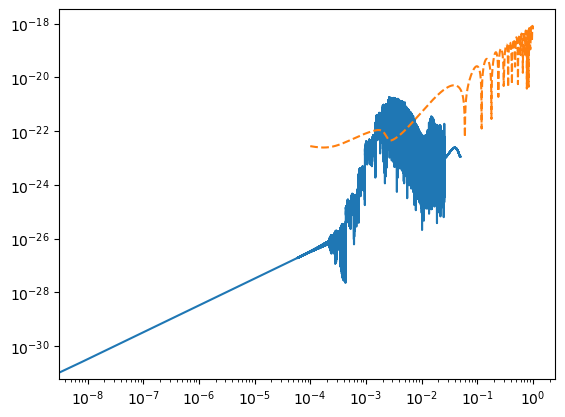

In [17]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

print(calculators["emri"].get_snr(*emri_injection_params))
Sn = get_sensitivity(fn, model=mrdv1, sens_fn=A1TDISens, **psd_kwargs)
emri_freqs = np.fft.rfftfreq(calculators["emri"].last_output[0].shape[0], calculators["emri"].aet_template_gen.dt)
plt.loglog(emri_freqs, emri_freqs * np.abs(np.fft.rfft(calculators["emri"].last_output[0])) * calculators["emri"].aet_template_gen.dt, c=f"C0")
plt.loglog(fn, np.sqrt(fn) * (Sn) ** (1/2), c=f"C1", ls="--")
